In [1]:
import time
import random
from collections import deque
import numpy as np
import gymnasium as gym
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt

2025-06-26 14:42:42.183778: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 14:42:42.295080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750941762.336939    3393 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750941762.349473    3393 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750941762.441820    3393 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 6.1. Introduction to Reinforcement Learning

For the problem formulation, we introduce the [gymnasium](https://gymnasium.farama.org/) library. It implements control problems from the past and present of reinforcement learning that have served as milestones in the development of that technique. Researchers that work on the same standard problems have the advantage that their work is easier to compare and to transfer. On the other hand, if benchmark problems are too prevalent in a community, it may drive research in a certain, uniform direction that is not as productive anymore. 

gym uses a unifying framework that defines every control problem as an *environment*. The basic building blocks of an environment are `env = gym.make` to create the environment, `env.reset` to start an episode, `env.render` to give a human readable representation of the state of the environment, and `env.step` to perform an action.

We start the exercises with the 4x4 [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) environment. It is a kind of maze with "frozen" traversable squares marked by `F` and "holes", losing terminal squares marked by `H`. The agent starts at the `S` start square and only incurs reward, when they manage to get to the goal `G` square. We mostly look at the deterministic case, where traversing on the frozen lake is deterministic, which is controlled by the variable `is_slippery=False` when creating the environment. If the lake is slippery, a movement in a certain direction may by chance result in the agent arriving at a different square than expected.

In [164]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="human")
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(16)


In [165]:
starting_state, _= env.reset()
time.sleep(1)
env.close()

The `env.action_space` always implements a `sample` method, which returns a valid, random aciton. We can utilize this, to have a look at the dynamics of the system. You can execute the following cell a few times to see what happens. When the agent enters a terminal state, you need to execute `env.reset` to start anew.

In [178]:
env = gym.make('FrozenLake-v1', is_slippery=False, render_mode=None)
starting_state, _ = env.reset()

In [193]:
state, reward, terminated, truncated, info = env.step(env.action_space.sample())
print(state, reward, terminated, truncated, info)
env.close()

7 0 True False {'prob': 1.0}


#### Task 1. a) Random Agent:
We provide the framework for the random agent, a method to rollout a policy

In [194]:
def rollout(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.action(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    return total_reward

class RandomAgent:
    def __init__(self, action_space, observation_space):
        self.action_space = action_space
        self.observation_space = observation_space
        
    # We pass the state only for compatability
    def action(self, state):
        return self.action_space.sample()

def compute_avg_return(env, agent, num_episodes=5000):
    total_return = 0
    for _ in range(num_episodes):
        episode_return = rollout(env, agent)
        total_return += episode_return
    avg_reward = total_return / num_episodes
    return avg_reward

Add your code to estimate the `avg_return_random_agent` for the deterministic case and `avg_return_random_agent_slippery` for the stochastic case!

In [195]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)
random_agent = RandomAgent(env.action_space, env.observation_space)
avg_return_random_agent = compute_avg_return(env, random_agent)

env_slippery = gym.make("FrozenLake-v1", is_slippery=True, render_mode=None)
random_agent_slippery = RandomAgent(env_slippery.action_space, env_slippery.observation_space)
avg_return_random_agent_slippery = compute_avg_return(env_slippery, random_agent_slippery)

In [196]:
print("Estimation for the deterministic case:", avg_return_random_agent)
print("Estimation for the stochastic case:", avg_return_random_agent_slippery)

Estimation for the deterministic case: 0.012
Estimation for the stochastic case: 0.013


### 1. b) Iterative Policy Evaluation
We provide a `set_state` method that changes the state of the environment. This is a pretty unusual way to interact with this framework. Note, that the random policy is stochastic, while the environment is not. In the value update we sum the value of each possible action that is weighted by its probability to be picked by the action. The architecture of the agent does provide access to these inner dynamics, so instead of passing the agent or its dynamics as a variable, we implement iterative policy evaluation just for the random agent, with the probability of `0.25` for each action hard coded.

We also provide `all_states` and `all_actions`, lists of all admissable states and actions for the environment. 

In [5]:
all_states = list(range(env.observation_space.n))
all_actions = list(range(env.action_space.n))

print(f"Actions: {all_actions}, States: {all_states}")

def set_state(env, state):
    env.reset()
    env.unwrapped.s = state
    return env

def visualize_value_fct(v):
    print(np.round(np.array(list(v.values())).reshape((4,4)),3))

Actions: [0, 1, 2, 3], States: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
def iterative_policy_iteration_random_agent(env, all_states, all_actions, discount_rate, 
                                            threshold=0.001, max_iter=10000):
    v = {s: 0 for s in all_states}
    
    action_prob = 1.0 / len(all_actions)
    
    for iteration in range(max_iter):
        v_old = v.copy()
        
        # update value for each state
        for s in all_states:
            new_value = 0
            
            for a in all_actions:
                set_state(env, s)
                next_state, reward, terminated, truncated, _ = env.step(a)
                
                # terminal -> value of next_state is 0 (no future rewards)
                if terminated or truncated:
                    next_value = 0
                else:
                    next_value = v_old[next_state]
                
                new_value += action_prob * (reward + discount_rate * next_value)
            
            v[s] = new_value
        
        # converged?
        max_diff = max(abs(v[s] - v_old[s]) for s in all_states)
        if max_diff < threshold:
            print(f"Converged after {iteration + 1} iterations")
            break
    
    return v

In [ ]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)
v_random = iterative_policy_iteration_random_agent(env, all_states, all_actions, discount_rate=0.9)
print("Value function for deterministic case:")
visualize_value_fct(v_random)

env_slippery = gym.make("FrozenLake-v1", is_slippery=True, render_mode=None)
all_states_slip = list(range(env_slippery.observation_space.n))
all_actions_slip = list(range(env_slippery.action_space.n))

v_random_slippery = iterative_policy_iteration_random_agent(env_slippery, all_states_slip, all_actions_slip, discount_rate=0.9)
print("\nValue function for stochastic case:")
visualize_value_fct(v_random_slippery)

Converged after 11 iterations
Value function for deterministic case:
[[0.003 0.003 0.009 0.003]
 [0.006 0.    0.026 0.   ]
 [0.018 0.056 0.106 0.   ]
 [0.    0.129 0.39  0.   ]]

Value function for stochastic case:
[[0.007 0.003 0.032 0.004]
 [0.004 0.    0.    0.   ]
 [0.006 0.047 0.032 0.   ]
 [0.    0.312 0.236 0.   ]]


Sometims the value function for the stochastic case is just 0 everywhere and I am not 100% sure why this happens! If that should be the case execute cell again!

### 1. c) Value Iteration
Use value iteration to find the optimal policy!

In [201]:
def value_iteration(env, all_states, all_actions, discount_rate, threshold=0.001, max_iter=10000):
    v = {s: 0 for s in all_states}
    
    for iteration in range(max_iter):
        v_old = v.copy()
        
        # Update value for each state
        for s in all_states:

            # now maximum value for each state
            max_value = float('-inf')
            
            for a in all_actions:
                set_state(env, s)
                next_state, reward, terminated, truncated, _ = env.step(a)
                
                if terminated or truncated:
                    action_value = reward
                else:
                    action_value = reward + discount_rate * v_old[next_state]
                
                max_value = max(max_value, action_value)
            
            v[s] = max_value
        
        max_diff = max(abs(v[s] - v_old[s]) for s in all_states)
        if max_diff < threshold:
            print(f"Converged after {iteration + 1} iterations")
            break
    
    return v

In [214]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)
v_optimal = value_iteration(env, all_states, all_actions, discount_rate=0.9)
visualize_value_fct(v_optimal)

Converged after 7 iterations
[[0.59  0.656 0.729 0.656]
 [0.656 0.    0.81  0.   ]
 [0.729 0.81  0.9   0.   ]
 [0.    0.9   1.    0.   ]]


In [215]:
def extract_optimal_policy(env, v_optimal, all_states, all_actions, discount_rate):
    policy = {}
    
    for s in all_states:
        best_action = None
        best_value = float('-inf')
        
        for a in all_actions:
            set_state(env, s)
            next_state, reward, terminated, truncated, _ = env.step(a)
            
            if terminated or truncated:
                action_value = reward
            else:
                action_value = reward + discount_rate * v_optimal[next_state]
            
            if action_value > best_value:
                best_value = action_value
                best_action = a
        
        policy[s] = best_action
    
    return policy

optimal_policy = extract_optimal_policy(env, v_optimal, all_states, all_actions, 0.9)

class OptimalPolicyAgent:
    def __init__(self, policy):
        self.policy = policy
    
    def action(self, state):
        return self.policy[state]

optimal_agent = OptimalPolicyAgent(optimal_policy)
avg_return_optimal = compute_avg_return(env, optimal_agent, num_episodes=1000)
print(f"\nAverage return of optimal policy: {avg_return_optimal}")
print(optimal_policy)


Average return of optimal policy: 1.0
{0: 1, 1: 2, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 0, 13: 2, 14: 2, 15: 0}


In [ ]:
def watch_agent_play(env_name, agent, num_episodes=1, sleep_time=0.5, is_slippery=False):
    # Create environment with human rendering
    env_visual = gym.make(env_name, is_slippery=is_slippery, render_mode="human")
    
    for episode in range(num_episodes):
        print(f"\nEpisode {episode + 1}")
        state, _ = env_visual.reset()
        env_visual.render()
        time.sleep(sleep_time)
        
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            action = agent.action(state)
            action_names = ["LEFT", "DOWN", "RIGHT", "UP"]
            print(f"State: {state}, Action: {action_names[action]}")
            
            state, reward, terminated, truncated, _ = env_visual.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
            
            env_visual.render()
            time.sleep(sleep_time)
            
            if done:
                if reward > 0:
                    print(f"Reward: {total_reward}, Steps: {steps}")
                else:
                    print(f"Reward: {total_reward}, Steps: {steps}")
    
    env_visual.close()

print("Random:")
random_agent = RandomAgent(env.action_space, env.observation_space)
watch_agent_play("FrozenLake-v1", random_agent, num_episodes=1, sleep_time=0.3)

print("\nOptimalPolicy:")
optimal_agent = OptimalPolicyAgent(optimal_policy)
watch_agent_play("FrozenLake-v1", optimal_agent, num_episodes=1, sleep_time=0.3)

print("\nOptimalPolicy on ice:")
watch_agent_play("FrozenLake-v1", optimal_agent, num_episodes=1, sleep_time=0.3, is_slippery=True)

Random:

--- Episode 1 ---
State: 0, Action: LEFT
State: 0, Action: RIGHT
State: 1, Action: UP
State: 1, Action: RIGHT
State: 2, Action: UP
State: 2, Action: DOWN
State: 6, Action: DOWN
State: 10, Action: DOWN
State: 14, Action: LEFT
State: 13, Action: UP
State: 9, Action: UP
Reward: 0.0, Steps: 11

OptimalPolicy:

--- Episode 1 ---
State: 0, Action: DOWN
State: 4, Action: DOWN
State: 8, Action: RIGHT
State: 9, Action: DOWN
State: 13, Action: RIGHT
State: 14, Action: RIGHT
Reward: 1.0, Steps: 6

OptimalPolicy on ice:

--- Episode 1 ---
State: 0, Action: DOWN
State: 1, Action: RIGHT
State: 2, Action: DOWN
State: 1, Action: RIGHT
Reward: 0.0, Steps: 4


### 2. a) Sarsa & Q-Learning
With the language of a Q-table, we can define a more general agent by a Q-function.

*Please do not use* `set_state` *anymore! Instead always start an episode with* `state = env.reset()`!

In [30]:
def visualize_q_fct(q):
    acts = {0 : "L", 1 : "D", 2 : "R", 3 : "U"} 
    for j in range(4):
        print("Value for action", acts[j], ":")
        print(np.round(np.array([q[i][j] for i in range(16)]).reshape((4,4)), 3))
    for i in range(4):
        print([acts[np.argmax(q[4*i + j])] for j in range(4)])
        
def argmax_tiebreak(array):
    return np.random.choice(np.where(array == array.max())[0])

In [ ]:
class Discrete_Q_Agent:
    def __init__(self, action_space, observation_space, epsilon=0.9):
        self.action_space = action_space
        self.observation_space = observation_space
        self.epsilon = epsilon
        self.reset_Q()
    
    def reset_Q(self):
        all_states = list(range(self.observation_space.n))
        self.actions = list(range(self.action_space.n))
        self.Q = {s: np.zeros(self.action_space.n) for s in all_states}

    def action(self, state):
        # epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            # explore
            action = np.random.choice(self.actions)
        else:
            # exploit
            action = argmax_tiebreak(self.Q[state])
        return action

In [218]:
def Sarsa(env, q_agent, alpha=0.1, gamma=0.99, rollouts=10000):
    
    for episode in range(rollouts):

        state, _ = env.reset()
        action = q_agent.action(state)
        done = False
        
        # decay epsilon
        q_agent.epsilon = max(0.01, q_agent.epsilon * 0.9999)
        
        while not done:
            # take action A observe R, S'
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            next_action = q_agent.action(next_state)
            
            # Q(S,A) <- Q(S,A) + alpha[R + gammaQ(S',A') - Q(S,A)]
            td_target = reward + gamma * q_agent.Q[next_state][next_action] * (not done)
            td_error = td_target - q_agent.Q[state][action]
            q_agent.Q[state][action] += alpha * td_error
            
            state = next_state
            action = next_action
    
    return q_agent, q_agent.Q

In [220]:
def Q_Learning(env, q_agent, alpha=0.1, gamma=0.99, rollouts=10000):
    
    for episode in range(rollouts):
        state, _ = env.reset()
        done = False
        
        q_agent.epsilon = max(0.01, q_agent.epsilon * 0.9999)
        
        while not done:
            action = q_agent.action(state)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if done:
                td_target = reward
            else:
                # now use best action in situation i.e. maximum reward from here on out and not what the policy would get
                td_target = reward + gamma * np.max(q_agent.Q[next_state])
            
            td_error = td_target - q_agent.Q[state][action]
            q_agent.Q[state][action] += alpha * td_error
            
            state = next_state
    
    return q_agent, q_agent.Q

In [221]:
env_slippery = gym.make("FrozenLake-v1", is_slippery=True)
q_agent = Discrete_Q_Agent(env_slippery.action_space, env_slippery.observation_space, epsilon=0.9)
q_agent, q = Sarsa(env_slippery, q_agent)
visualize_q_fct(q)

Value for action L :
[[0.091 0.053 0.087 0.043]
 [0.129 0.    0.143 0.   ]
 [0.111 0.188 0.263 0.   ]
 [0.    0.226 0.482 0.   ]]
Value for action D :
[[0.1   0.055 0.072 0.027]
 [0.052 0.    0.073 0.   ]
 [0.096 0.277 0.234 0.   ]
 [0.    0.354 0.593 0.   ]]
Value for action R :
[[0.089 0.036 0.082 0.022]
 [0.074 0.    0.115 0.   ]
 [0.082 0.258 0.205 0.   ]
 [0.    0.423 0.579 0.   ]]
Value for action U :
[[0.088 0.087 0.071 0.064]
 [0.058 0.    0.027 0.   ]
 [0.199 0.194 0.125 0.   ]
 [0.    0.127 0.491 0.   ]]
['D', 'U', 'L', 'U']
['L', 'L', 'L', 'L']
['U', 'D', 'L', 'L']
['L', 'R', 'D', 'L']


In [222]:
env_slippery = gym.make("FrozenLake-v1", is_slippery=True)
q_agent = Discrete_Q_Agent(env_slippery.action_space, env_slippery.observation_space, epsilon=0.9)
q_agent, q = Q_Learning(env_slippery, q_agent)
visualize_q_fct(q)

Value for action L :
[[0.572 0.352 0.453 0.341]
 [0.583 0.    0.4   0.   ]
 [0.468 0.419 0.609 0.   ]
 [0.    0.476 0.764 0.   ]]
Value for action D :
[[0.57  0.445 0.455 0.321]
 [0.269 0.    0.33  0.   ]
 [0.43  0.635 0.568 0.   ]
 [0.    0.466 0.874 0.   ]]
Value for action R :
[[0.567 0.26  0.435 0.295]
 [0.362 0.    0.418 0.   ]
 [0.251 0.466 0.404 0.   ]
 [0.    0.717 0.796 0.   ]]
Value for action U :
[[0.559 0.527 0.49  0.466]
 [0.313 0.    0.131 0.   ]
 [0.608 0.372 0.325 0.   ]
 [0.    0.534 0.798 0.   ]]
['L', 'U', 'U', 'U']
['L', 'L', 'R', 'L']
['U', 'D', 'L', 'L']
['L', 'R', 'D', 'L']


In [223]:
print("\nQ-AGENT on ice:")
q_agent.epsilon = 0
watch_agent_play("FrozenLake-v1", q_agent, num_episodes=1, sleep_time=0.3, is_slippery=True)


Q-AGENT on ice:

--- Episode 1 ---
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 4, Action: LEFT
State: 4, Action: LEFT
State: 0, Action: LEFT
State: 4, Action: LEFT
State: 8, Action: UP
State: 9, Action: DOWN
State: 13, Action: RIGHT
State: 9, Action: DOWN
State: 10, Action: LEFT
State: 6, Action: RIGHT
State: 2, Action: UP
State: 1, Action: UP
State: 2, Action: UP
State: 2, Action: UP
State: 1, Action: UP
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 4, Action: LEFT
State: 4, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 4, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 4, Action: LEFT
State: 8, Action: UP
State: 8, Action: UP
State: 4, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 0, Action: LEFT
State: 4, 

### 2. b) Cartpole
Next, try the [Cartpole](https://www.gymlibrary.ml/environments/classic_control/cart_pole/) environment. It has a continuous state space, so we need to adjust our methods to accomodate that.

In [224]:
env = gym.make("CartPole-v1", render_mode=None)
print(env.action_space)
action = env.action_space.sample()
print(action)


print(f"Action space: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")
print(f"Observation space: {env.observation_space}")
print(f"Observation shape: {env.observation_space.shape}")
print(f"Observation bounds:")
print(f"  Low:  {env.observation_space.low}")
print(f"  High: {env.observation_space.high}")

print("\nState variables:")
print("  [0] Cart Position")
print("  [1] Cart Velocity") 
print("  [2] Pole Angle")
print("  [3] Pole Angular Velocity")

print("\nActions:")
print("  0: Push cart to the left")
print("  1: Push cart to the right")

Discrete(2)
0
Action space: Discrete(2)
Number of actions: 2
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Observation shape: (4,)
Observation bounds:
  Low:  [-4.8               -inf -0.41887903        -inf]
  High: [4.8               inf 0.41887903        inf]

State variables:
  [0] Cart Position
  [1] Cart Velocity
  [2] Pole Angle
  [3] Pole Angular Velocity

Actions:
  0: Push cart to the left
  1: Push cart to the right


In [ ]:
def rollout(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.action(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    return total_reward

class RandomAgent:
    def __init__(self, action_space, observation_space):
        self.action_space = action_space
        self.observation_space = observation_space
        
    # We pass the state only for compatability
    def action(self, state):
        return self.action_space.sample()

def compute_avg_return(env, agent, num_episodes=5000):
    total_return = 0
    for _ in range(num_episodes):
        episode_return = rollout(env, agent)
        total_return += episode_return
    avg_reward = total_return / num_episodes
    return avg_reward

def render_rollout(agent):
    env = gym.make('CartPole-v1', render_mode='human')
    print("Rendering one episode...")
    observation, _ = env.reset()
    total_reward = 0
    step = 0
    done = False
    
    while not done:
        env.render()
        action = agent.action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        step += 1
        done = terminated or truncated
        time.sleep(0.2)

    env.close()
    
    print(f"Episode finished after {step} steps with total reward: {total_reward}")

In [226]:
env = gym.make('CartPole-v1', render_mode=None)
random_agent = RandomAgent(env.action_space, env.observation_space)
avg_return_random_agent = compute_avg_return(env, random_agent)
print("Estimation for average return:", avg_return_random_agent)

Estimation for average return: 22.3692


In [227]:
render_rollout(random_agent)

Rendering one episode...
Episode finished after 11 steps with total reward: 11.0


### 2. c) Cartpole learning
The observation space of the Cartpole environment can be accessed with `env.observation_space`. It is a [`Box`](https://gymnasium.farama.org/api/spaces/fundamental/#box) space, which contains lower bounds, upper bounds, number of dimensions, and datatype. The second and forth dimension are unbounded. We can make them bounded by clipping every value over a certain threshold. Also, the first and third dimension have higher admissbable bounds, than is useful during training!

Hint: Binned Q-Learning is not the most efficient or useful algorithm for this problem. With the provided hyperparameters I achieved only a mean reward of ~100 after 50000 rollouts of training without any further tuning. Can you achieve a better result by changing the hyperparameters or employing some additional technique?

Starting binned Q-learning...
Episode 0, Avg Reward (last 1000): 17.0, Epsilon: 0.8995500000000001
Episode 5000, Avg Reward (last 1000): 48.271, Epsilon: 0.07379340982621711
Episode 10000, Avg Reward (last 1000): 86.104, Epsilon: 0.01
Episode 15000, Avg Reward (last 1000): 122.521, Epsilon: 0.01
Episode 20000, Avg Reward (last 1000): 146.601, Epsilon: 0.01
Episode 25000, Avg Reward (last 1000): 140.257, Epsilon: 0.01
Episode 30000, Avg Reward (last 1000): 156.048, Epsilon: 0.01
Episode 35000, Avg Reward (last 1000): 181.493, Epsilon: 0.01
Episode 40000, Avg Reward (last 1000): 149.811, Epsilon: 0.01
Episode 45000, Avg Reward (last 1000): 158.156, Epsilon: 0.01

Final average reward (last 1000 episodes): 203.862
Average test reward: [144.0, 128.0, 225.0, 23.0, 210.0, 137.0, 243.0, 231.0, 192.0, 199.0, 150.0, 257.0, 138.0, 196.0, 290.0, 198.0, 229.0, 235.0, 215.0, 162.0, 229.0, 202.0, 100.0, 153.0, 220.0, 182.0, 222.0, 209.0, 107.0, 116.0, 138.0, 204.0, 138.0, 116.0, 243.0, 143.0, 96.0, 

/tmp/ipykernel_5067/1343043851.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


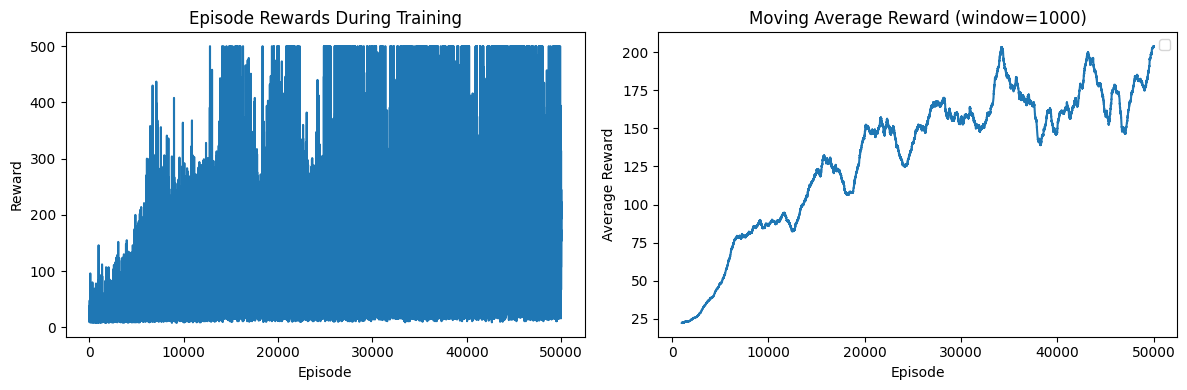

In [228]:
learning_rate = 0.1
discounting_rate = 0.95
number_episodes = 50000
total_reward = 0

q_table = np.zeros([31, 31, 51, 51, 2])
window_size = np.array([0.25, 0.25, 0.01, 0.1])
low_clip = [-3.75, -3.75, -0.25, -2.5]
high_clip = [3.75, 3.75, 0.25, 2.5]

def argmax_tiebreak(q_values):
    """Argmax with random tie-breaking"""
    return np.random.choice(np.where(q_values == np.max(q_values))[0])

class Binned_Q_Agent_Cartpole:
    def __init__(self, window_size, q_table, epsilon=0.9):
        self.window_size = window_size
        self.q_table = q_table
        self.epsilon = epsilon
        
        self.low_clip = low_clip
        self.high_clip = high_clip
        
        # bin ranges calculation
        self.bin_ranges = []
        for i in range(4):
            low = self.low_clip[i]
            high = self.high_clip[i]
            n_bins = q_table.shape[i]
            self.bin_ranges.append(np.linspace(low, high, n_bins))
    
    def discretize_state(self, state):

        discrete_state = []
        
        for i in range(4):
            # clipping
            clipped_val = np.clip(state[i], self.low_clip[i], self.high_clip[i])
            
            # sort in bins
            bin_idx = np.digitize(clipped_val, self.bin_ranges[i]) - 1
            
            bin_idx = np.clip(bin_idx, 0, self.q_table.shape[i] - 1)
            discrete_state.append(bin_idx)
        
        return tuple(discrete_state)
    
    def action(self, state):

        discrete_state = self.discretize_state(state)
        
        if np.random.random() < self.epsilon:
            # explore
            return np.random.choice([0, 1])
        else:
            # exploit
            q_values = self.q_table[discrete_state]
            return argmax_tiebreak(q_values)
    
    def update_q_value(self, state, action, reward, next_state, learning_rate, discount_rate, done):

        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        
        current_q = self.q_table[discrete_state + (action,)]
        
        if done:
            target = reward
        else:
            next_q_values = self.q_table[discrete_next_state]
            target = reward + discount_rate * np.max(next_q_values)
        
        # update as described in algorithm
        td_error = target - current_q
        self.q_table[discrete_state + (action,)] += learning_rate * td_error

def binned_q_learning(env, agent, num_episodes=50000, learning_rate=0.1, discount_rate=0.95):
    episode_rewards = []
    episode_lengths = []
    
    print("Starting binned Q-learning...")
    
    for episode in range(num_episodes):
        # Reset environment
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        # epsilon decay
        agent.epsilon = max(0.01, agent.epsilon * 0.9995)
        
        while not done and steps < 500:

            action = agent.action(state)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.update_q_value(state, action, reward, next_state, 
                               learning_rate, discount_rate, done)
            
            state = next_state
            total_reward += reward
            steps += 1
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        # see progress
        if episode % 5000 == 0:
            avg_reward = np.mean(episode_rewards[-1000:]) if len(episode_rewards) >= 1000 else np.mean(episode_rewards)
            print(f"Episode {episode}, Avg Reward (last 1000): {avg_reward}, Epsilon: {agent.epsilon}")
    
    # results
    final_avg = np.mean(episode_rewards[-1000:])
    print(f"\nFinal average reward (last 1000 episodes): {final_avg}")
    
    return episode_rewards, episode_lengths

def test_policy(env, agent, episodes=100):

    original_epsilon = agent.epsilon
    agent.epsilon = 0  # no exploration
    
    test_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < 500:
            action = agent.action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            steps += 1
        
        test_rewards.append(total_reward)
    
    agent.epsilon = original_epsilon
    return test_rewards

def plot_results(episode_rewards):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(1, 2, 2)

    window = 1000
    if len(episode_rewards) >= window:
        moving_avg = []
        for i in range(window-1, len(episode_rewards)):
            moving_avg.append(np.mean(episode_rewards[i-window+1:i+1]))
        
        plt.plot(range(window-1, len(episode_rewards)), moving_avg)
        plt.title(f'Moving Average Reward (window={window})')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

env = gym.make("CartPole-v1")
bagent = Binned_Q_Agent_Cartpole(window_size, q_table)

# Run training
episode_rewards, episode_lengths = binned_q_learning(env, bagent, number_episodes, learning_rate, discounting_rate)

test_reward = test_policy(env, bagent)
print(f"Average test reward: {test_reward}")

plot_results(episode_rewards)

Above algorithm not 100% stable but was able to achieve over 200 from time to time with these hyperparameters!

### 3.a) Linear function control
Implement the linear gradient Sarsa here. Most of the time after a few thousend episodes the linear policy is able to solve the problem (500 reward), but sometimes it just does not converge. The algorithm is a bit shakey as is! I also needed to add one little tweak: Normalize the state by clipping it, just as in the task before, and then dividing by the clip-value. This normalizes the state-vectors to [-1,1] and stablizes the algorithm.

Note that for a linear formulation of Q_theta(., a), Grad(Q_theta(., a)) at state vector s is just that state vector s.


Try: 1
Episode 0, Avg Reward (last 100): 16.0, Epsilon: 0.8995500000000001
Episode 1000, Avg Reward (last 100): 24.02, Epsilon: 0.5455364358858058
Episode 2000, Avg Reward (last 100): 27.4, Epsilon: 0.3308432025779433
Episode 3000, Avg Reward (last 100): 27.75, Epsilon: 0.20064145580725617
Episode 4000, Avg Reward (last 100): 27.3, Epsilon: 0.12167997853596811
Episode 5000, Avg Reward (last 100): 26.97, Epsilon: 0.07379340982621711
Episode 6000, Avg Reward (last 100): 26.98, Epsilon: 0.04475236928292495
Episode 7000, Avg Reward (last 100): 26.95, Epsilon: 0.027140290185150764
Episode 8000, Avg Reward (last 100): 27.14, Epsilon: 0.016459359876064356
Episode 9000, Avg Reward (last 100): 26.81, Epsilon: 0.01

training completed
final average reward (last 100 episodes): 26.41

Test Results (100 episodes):
Average test reward: 27.14
Max test reward: 46.0
Min test reward: 20.0

Try: 2
Episode 0, Avg Reward (last 100): 38.0, Epsilon: 0.8995500000000001
Episode 1000, Avg Reward (last 100): 18

/tmp/ipykernel_5067/728642689.py:147: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


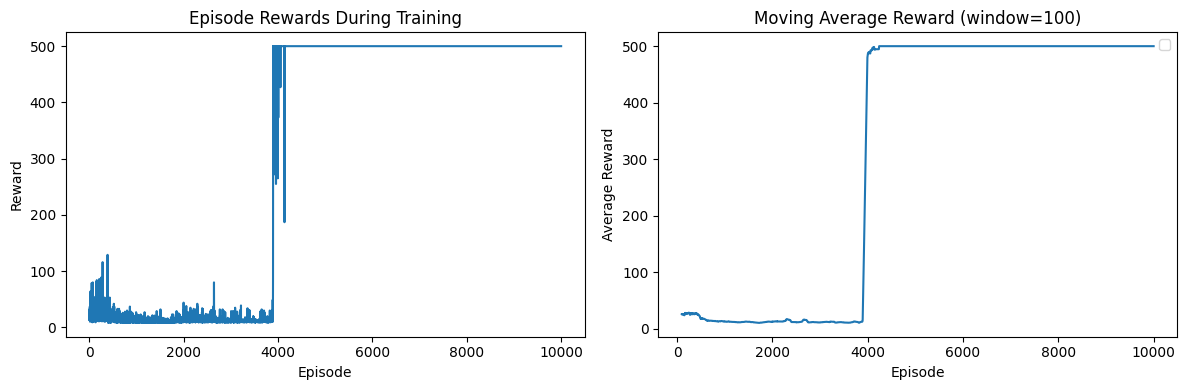

In [231]:
low_clip = np.array([-3.75, -3.75, -0.25, -2.5])
high_clip = np.array([3.75, 3.75, 0.25, 2.5])

class Linear_Q_Agent:
    def __init__(self, action_space, observation_space, epsilon=0.9):
        self.action_space = action_space
        self.observation_space = observation_space
        self.epsilon = epsilon
        self.theta = np.zeros((action_space.n, observation_space.shape[0]))
        
    def norm_state(self, state):
        norm_state = state.copy()
        norm_state = np.clip(norm_state, low_clip, high_clip)
        norm_state = norm_state / high_clip
        return norm_state
    
    def q_value(self, state, action):
        """Compute Q-value for a specific state-action pair"""
        norm_state = self.norm_state(state)
        return np.dot(self.theta[action], norm_state)
    
    def q_values(self, state):
        """Compute Q-values for all actions given a state"""
        norm_state = self.norm_state(state)
        return np.dot(self.theta, norm_state)
    
    def action(self, state):
        if np.random.random() < self.epsilon:
            # explore
            return self.action_space.sample()
        else:
            # exploit
            q_vals = self.q_values(state)
            max_q = np.max(q_vals)
            max_actions = np.where(np.abs(q_vals - max_q) < 1e-8)[0]
            return np.random.choice(max_actions)
    
    def gradient(self, state, action):
        """Gradient of Q with respect to theta for linear approximation"""
        # For Q(s,a) = theta[a] . s, gradient w.r.t. theta[a] is just s
        return self.norm_state(state)

def Grad_Sarsa(env, agent, rollouts=10000, learning_rate=0.1, discount_rate=0.95):
    """
    Gradient-based SARSA algorithm for linear function approximation
    Following Algorithm 5.9
    """
    episode_rewards = []
    
    for episode in range(rollouts):

        state, _ = env.reset()
        total_reward = 0

        action = agent.action(state)
        
        done = False
        steps = 0
        while not done and steps < 500:

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if done:
                current_q = agent.q_value(state, action)
                td_error = reward - current_q
                gradient = agent.gradient(state, action)
                agent.theta[action] += learning_rate * td_error * gradient
            else:
                next_action = agent.action(next_state)
                
                current_q = agent.q_value(state, action)
                next_q = agent.q_value(next_state, next_action)
                td_target = reward + discount_rate * next_q
                td_error = td_target - current_q
                
                gradient = agent.gradient(state, action)
                agent.theta[action] += learning_rate * td_error * gradient
                
                state = next_state
                action = next_action
            
            total_reward += reward
            steps += 1
        
        episode_rewards.append(total_reward)
        
        # decay epsilon
        agent.epsilon = max(0.01, agent.epsilon * 0.9995)
        
        if episode % 1000 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode}, Avg Reward (last 100): {avg_reward}, Epsilon: {agent.epsilon}")
    
    print(f"\ntraining completed")
    print(f"final average reward (last 100 episodes): {np.mean(episode_rewards[-100:])}")
    
    return agent, episode_rewards

def test_policy(env, agent, episodes=100):

    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    test_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        
        test_rewards.append(total_reward)
    
    agent.epsilon = original_epsilon
    
    print(f"\nTest Results (100 episodes):")
    print(f"Average test reward: {np.mean(test_rewards)}")
    print(f"Max test reward: {np.max(test_rewards)}")
    print(f"Min test reward: {np.min(test_rewards)}")
    
    return test_rewards

def plot_training_progress(episode_rewards):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(1, 2, 2)

    window = 100
    if len(episode_rewards) >= window:
        moving_avg = [np.mean(episode_rewards[i-window+1:i+1]) 
                      for i in range(window-1, len(episode_rewards))]
        plt.plot(range(window-1, len(episode_rewards)), moving_avg)
        plt.title(f'Moving Average Reward (window={window})')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


env = gym.make("CartPole-v1")

converged_nicely = False
tries = 1

while not converged_nicely:

    print(f"\nTry: {tries}")
    
    lin_agent = Linear_Q_Agent(env.action_space, env.observation_space, epsilon=0.9)

    trained_agent, episode_rewards = Grad_Sarsa(env, lin_agent, rollouts=10000, learning_rate=0.1, discount_rate=0.95)
    test_rewards = test_policy(env, trained_agent)

    avg_test_rewards = np.mean(test_rewards)

    tries +=1

    if avg_test_rewards == 500.0:
        converged_nicely = True

print(f"\nFinal theta values:")
print(f"Action 0 (left): {trained_agent.theta[0]}")
print(f"Action 1 (right): {trained_agent.theta[1]}")

plot_training_progress(episode_rewards)

Irgendwie hat experimentieren das nur schlechter gemacht

### 3.b) DQN
As a suggestion, I provided the interfaces for functions, some hyperparameters, and the architecture of the neural net that approximates Q. For this algorithm to somewhat work, I needed at least experience replay. But other techniques may also be interesting and work even better. Please feel free to experiment!

*Note*: 1. Whenever you either `model.predict` oder `model.fit` you can gain a lot of performance if you do it as a batch. E.g. use 
```
X = []
y = []
for i in I:
    X.append(get_data(i))
    y.append(get_label(i))
model.fit(X,y)
```
instead of
```
for i in I:
    model.fit(get_data(i), get_label(i))
```

In [ ]:
memory_size = 2000
epsilon = 0.05
learning_rate = 0.001

class DQN_Agent:
    def _init_model(self, state_dim, action_dim, learning_rate):
        model = Sequential()
        model.add(Input(shape=(self.state_size,))) # 1st hidden layer; states as input
        model.add(Dense(32, activation='relu'))
        model.add(Dense(action_dim, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
        return model
        
    def action(self, state):
        pass
    
    def remember(self, state, action, reward, next_state, done):
        pass

    def learn_from_replay(self, batch_size):
        pass
    
def DQN(env, agent, replay_batch_size=128, rollouts=2000):
    pass

2025-06-25 16:43:01.349429: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Starting training:
Episode 100, Avg Reward: 21.91, Avg Steps: 21.91, Epsilon: 0.951217530242334
Episode 200, Avg Reward: 23.22, Avg Steps: 23.22, Epsilon: 0.9048147898403269
Episode 300, Avg Reward: 26.67, Avg Steps: 26.67, Epsilon: 0.8606756897186528
Episode 400, Avg Reward: 29.22, Avg Steps: 29.22, Epsilon: 0.8186898039137951
Episode 500, Avg Reward: 35.16, Avg Steps: 35.16, Epsilon: 0.7787520933134615
Episode 600, Avg Reward: 41.01, Avg Steps: 41.01, Epsilon: 0.7407626428726788
Episode 700, Avg Reward: 53.67, Avg Steps: 53.67, Epsilon: 0.7046264116491338
Episode 800, Avg Reward: 67.87, Avg Steps: 67.87, Epsilon: 0.6702529950324074
Episode 900, Avg Reward: 81.01, Avg Steps: 81.01, Epsilon: 0.637556398572254
Episode 1000, Avg Reward: 89.36, Avg Steps: 89.36, Epsilon: 0.606454822840097
Episode 1100, Avg Reward: 103.52, Avg Steps: 103.52, Epsilon: 0.5768704587855094
Episode 1200, Avg Reward: 107.65, Avg Steps: 107.65, Epsilon: 0.548729293075715
Episode 1300, Avg Reward: 147.26, Avg Step

/tmp/ipykernel_133613/3424645151.py:180: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_133613/3424645151.py:192: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


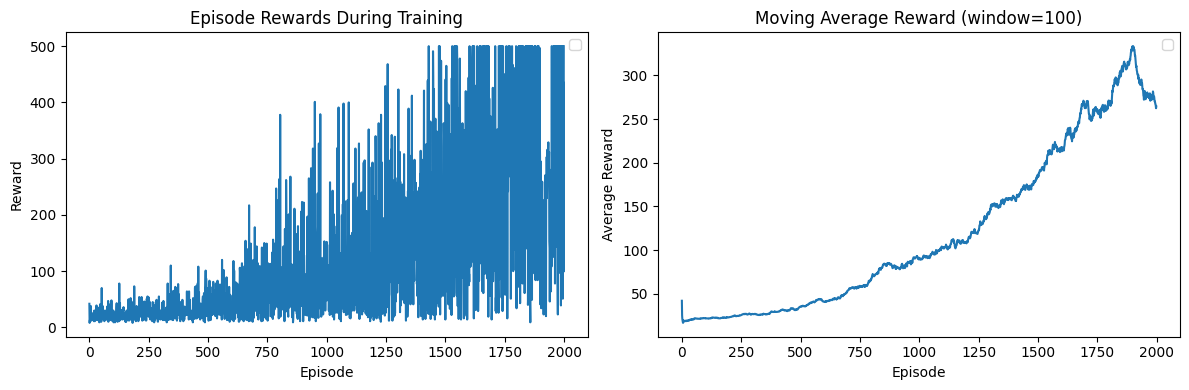

Rollout completed: Total reward = 500.0, Steps = 500


500.0

In [ ]:
memory_size = 2000
epsilon = 0.05
learning_rate = 0.001

class DQN_Agent:
    def __init__(self, state_size, action_size, learning_rate=0.001, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma

        self.memory = deque(maxlen=memory_size)
        
        self.model = self._build_model()
        
    def _build_model(self):
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
        
    def action(self, state):
        if np.random.random() <= self.epsilon:
            return np.random.randint(self.action_size)
        # reshape for predection
        state = state.reshape(1, -1)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def learn_from_replay(self, batch_size):

        if len(self.memory) < batch_size:
            return
        
        # sample experience
        batch = random.sample(self.memory, batch_size)
        
        # get components
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        # Predict Q-values for ALL current states and next states in ONE call each
        current_q_values = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)
        
        targets = current_q_values.copy()
        
        for i in range(batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                # Q-learning update
                targets[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
        
        self.model.fit(states, targets, epochs=1, verbose=0, batch_size=batch_size)

def DQN(env, agent, replay_batch_size=128, rollouts=2000):

    episode_rewards = []
    steps_per_episode = []
    
    print("Starting training:")
    
    for episode in range(rollouts):
        state, _ = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < 500:

            action = agent.action(state)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        
            agent.remember(state, action, reward, next_state, done)
            
            # learn from replay reduced because of run time
            if len(agent.memory) >= replay_batch_size and steps % 4 == 0:
                agent.learn_from_replay(replay_batch_size)
            
            state = next_state
            total_reward += reward
            steps += 1
        
        episode_rewards.append(total_reward)
        steps_per_episode.append(steps)
        
        # decay epsilon
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(steps_per_episode[-100:])
            print(f"Episode {episode + 1}, Avg Reward: {avg_reward}, "f"Avg Steps: {avg_steps}, Epsilon: {agent.epsilon}")
            
    print(f"Final average reward (last 100 episodes): {np.mean(episode_rewards[-100:])}")
    
    return agent, episode_rewards

def test_dqn_policy(env, agent, episodes=100):

    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    test_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < 500:
            action = agent.action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
        
        test_rewards.append(total_reward)
    
    agent.epsilon = original_epsilon  # Restore original epsilon
    
    print(f"Average test reward: {np.mean(test_rewards)}")
    print(f"Max test reward: {np.max(test_rewards)}")
    print(f"Min test reward: {np.min(test_rewards)}")
    print(f"Success rate (>=195): {sum(r >= 195 for r in test_rewards)/len(test_rewards)*100}%")
    print(f"Perfect score rate (500): {sum(r >= 500 for r in test_rewards)/len(test_rewards)*100}%")
    
    return test_rewards

def render_rollout(env, agent):

    render_env = gym.make("CartPole-v1", render_mode="human")
    
    state, _ = render_env.reset()
    total_reward = 0
    done = False
    steps = 0
    
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    while not done and steps < 500:
        render_env.render()
        action = agent.action(state)
        state, reward, terminated, truncated, _ = render_env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1
    
    agent.epsilon = original_epsilon
    render_env.close()
    
    print(f"Rollout completed: Total reward = {total_reward}, Steps = {steps}")
    return total_reward

def plot_training_progress(episode_rewards):

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    
    plt.subplot(1, 2, 2)

    window = 100
    if len(episode_rewards) >= window:
        moving_avg = [np.mean(episode_rewards[max(0, i-window+1):i+1]) 
                      for i in range(len(episode_rewards))]
        plt.plot(moving_avg)
        plt.title(f'Moving Average Reward (window={window})')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

env = gym.make("CartPole-v1")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
    
agent = DQN_Agent(state_size=state_size, action_size=action_size, learning_rate=0.001, epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.05, gamma=0.99)
    
trained_agent, episode_rewards = DQN(env, agent, replay_batch_size=128, rollouts=2000)

test_rewards = test_dqn_policy(env, trained_agent)
    
plot_training_progress(episode_rewards)

epsilon decay is definetly way to slow here. Apparently it was already easily at 500 time steps maybe even much earlier but just confused by the random actions! But I have no time to experiment with that a lot more. Works I guess

In [5]:
render_rollout(env, trained_agent)

Rollout completed: Total reward = 500.0, Steps = 500


500.0

### 3.c) Another one (bites the dust)
Browse the [environments](https://gymnasium.farama.org/) to pick another challenge! Maybe even record a video with the [RecordVideo wrapper](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo)!

In [5]:
memory_size = 10000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
gamma = 0.99
target_update_frequency = 100

class DQN_Agent:
    def __init__(self, state_size, action_size, learning_rate=0.001, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        
        self.memory = deque(maxlen=memory_size)
        
        self.q_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_network()
        
    def _build_model(self):
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())
        
    def action(self, state):
        if np.random.random() <= self.epsilon:
            return np.random.randint(self.action_size)
        
        # reshape compatability
        state = state.reshape(1, -1)
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def learn_from_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        # sample from memory
        batch = random.sample(self.memory, batch_size)
        
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        current_q_values = self.q_network.predict(states, verbose=0)
        
        next_q_values = self.target_network.predict(next_states, verbose=0)
    
        targets = current_q_values.copy()
        
        for i in range(batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
        
        self.q_network.fit(states, targets, epochs=1, verbose=0, batch_size=batch_size)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def DQN_LunarLander(env, agent, replay_batch_size=32, episodes=1000):
    episode_rewards = []
    steps_per_episode = []
    epsilon_history = []
    
    print("Starting:")
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < 1000:
            action = agent.action(state)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.remember(state, action, reward, next_state, done)
            
            if len(agent.memory) >= replay_batch_size and steps % 4 == 0:
                agent.learn_from_replay(replay_batch_size)
            
            state = next_state
            total_reward += reward
            steps += 1
        
        episode_rewards.append(total_reward)
        steps_per_episode.append(steps)
        epsilon_history.append(agent.epsilon)
        
        agent.decay_epsilon()
        
        if (episode + 1) % target_update_frequency == 0:
            agent.update_target_network()
            print(f"Target network updated at episode {episode + 1}")
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(steps_per_episode[-100:])
            print(f"Episode {episode + 1}, Avg Reward: {avg_reward}, "
                  f"Avg Steps: {avg_steps}, Epsilon: {agent.epsilon}")
    
    final_avg = np.mean(episode_rewards[-100:])
    print(f"Final average reward (last 100 episodes): {final_avg}")
    
    return agent, episode_rewards, epsilon_history


def test_dqn_policy(env, agent, episodes=100):
    print(f"\ntesting trained policy:")
    
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    test_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < 1000:
            action = agent.action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
        
        test_rewards.append(total_reward)
    
    agent.epsilon = original_epsilon
    
    avg_reward = np.mean(test_rewards)
    max_reward = np.max(test_rewards)
    min_reward = np.min(test_rewards)
    
    print(f"Test Results:")
    print(f"Average reward: {avg_reward}")
    print(f"Max reward: {max_reward}")
    print(f"Min reward: {min_reward}")
    
    return test_rewards


def render_rollout(env, agent):

    print("\nRendering one rollout...")
    
    render_env = gym.make("LunarLander-v2", render_mode="human")
    
    state, _ = render_env.reset()
    total_reward = 0
    done = False
    steps = 0
    
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    while not done and steps < 1000:
        render_env.render()
        action = agent.action(state)
        state, reward, terminated, truncated, _ = render_env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1
    
    agent.epsilon = original_epsilon
    render_env.close()
    
    print(f"Rollout completed: Total reward = {total_reward}, Steps = {steps}")
    return total_reward


def plot_training_progress(episode_rewards, epsilon_history):

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    window = 100
    if len(episode_rewards) >= window:
        moving_avg = [np.mean(episode_rewards[max(0, i-window+1):i+1]) 
                      for i in range(len(episode_rewards))]
        plt.plot(moving_avg)
        plt.title(f'Moving Average Reward (window={window})')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(epsilon_history)
    plt.title('Epsilon Decay During Training')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


env = gym.make("LunarLander-v3")

state_size = env.observation_space.shape[0] 
action_size = env.action_space.n

agent = DQN_Agent(
    state_size=state_size, 
    action_size=action_size, 
    learning_rate=learning_rate,
    epsilon=epsilon_start,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_end,
    gamma=gamma
)

trained_agent, episode_rewards, epsilon_history = DQN_LunarLander(env, agent, replay_batch_size=32, episodes=1000)

test_rewards = test_dqn_policy(env, trained_agent, episodes=100)

plot_training_progress(episode_rewards, epsilon_history)


I0000 00:00:1750941864.305151    3393 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5825 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Starting:


I0000 00:00:1750941864.803306    7785 service.cc:152] XLA service 0x7f26a8004910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750941864.803322    7785 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-06-26 14:44:24.810764: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750941864.829214    7785 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750941865.466603    7785 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Target network updated at episode 100
Episode 100, Avg Reward: -156.78955754030778, Avg Steps: 106.56, Epsilon: 0.6057704364907278
Target network updated at episode 200
Episode 200, Avg Reward: -134.12061262878598, Avg Steps: 229.08, Epsilon: 0.3669578217261671
Target network updated at episode 300
Episode 300, Avg Reward: -102.08460666958774, Avg Steps: 384.21, Epsilon: 0.22229219984074702
Target network updated at episode 400
Episode 400, Avg Reward: -47.58546639499297, Avg Steps: 444.22, Epsilon: 0.1346580429260134
Target network updated at episode 500
Episode 500, Avg Reward: -57.57529693179506, Avg Steps: 695.69, Epsilon: 0.08157186144027828
Target network updated at episode 600
Episode 600, Avg Reward: -105.67803250435435, Avg Steps: 606.6, Epsilon: 0.0494138221100385
Target network updated at episode 700
Episode 700, Avg Reward: -72.94665611423909, Avg Steps: 829.26, Epsilon: 0.029933432588273214
Target network updated at episode 800
Episode 800, Avg Reward: -101.97298613225279,

KeyboardInterrupt: 

In [ ]:
render_rollout(env, trained_agent)

I didn't have time to really test out if this really works for the Lunar environment (running takes to long to get good parameters). However it looked promising.